# Introduction

This notebook demonstrates the use of PanCAKE with the NirCAM coronagraphs, and contrasts PanCAKE with default Pandeia coronagraphy calculations. In particular, it provides examples of:

* Constructing a NIRCam scene in both Pandeia and PanCAKE
* Importing a NIRCam scene built in Pandeia into PakCAKE
* Engine calculations using Pandeia's precomputed PSF library, in both Pandeia and PanCAKE
* Comparisons of Pandeia's precomputed PSF library with PanCAKE's on-the-fly PSF generation
* Comparisons of on-the-fly PSF generation with varying numbers of wavelength bins

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from stsci_pancake import scene, analysis, transformations, engine

from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.perform_calculation import perform_calculation as pandeia_calculation

from copy import deepcopy
import numpy as np
import time

# Constructing a Scene

We'll start by defining the source and instrument properties for our desired observation. 

In [2]:
engine.options.on_the_fly_PSFs = False

target_mV = 14.
ref_mV = 12.

target_Sp = 'a5v'
ref_Sp = 'a3v'

planet_a_mag = 20.5
planet_b_mag = 20.0

subarray = 'sub640'
filter_c = 'f210m'
mask_c = 'mask210r'

Now we'll load in a NIRCam template and configure the instrument for our observation.

Now we'll create a NIRCam template from Pandeia and configure the instrument for our observation. (In this case, it's already configured for an F210M observation, but we'll demonstrate setting the calculation keys regardless.)

In [3]:
# Load the template
config = build_default_calc('jwst', 'nircam', 'coronagraphy')
print(config.keys())
print(config['configuration']['instrument'])

# Set the coronagraph and filter
config['configuration']['detector']['subarray'] = subarray
config['configuration']['instrument']['aperture'] = mask_c
config['configuration']['instrument']['filter'] = filter_c

dict_keys(['configuration', 'scene', 'background', 'strategy', 'calculation'])
{'aperture': 'mask210r', 'disperser': None, 'filter': 'f210m', 'instrument': 'nircam', 'mode': 'coronagraphy'}


This template contains a scene with a single star. We'll set the star properties and then duplicate it to create a planetary companion.

In [4]:
# Pull out the target (the first entry in the 'scene' list)
targetstar = config['scene'][0]
targetstar['spectrum']['normalization']['type'] = 'photsys'
targetstar['spectrum']['normalization']['norm_flux'] = target_mV
targetstar['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
targetstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
del targetstar['spectrum']['normalization']['norm_wave'] # not needed for bandpass
del targetstar['spectrum']['normalization']['norm_waveunit'] # not needed for bandpass
targetstar['spectrum']['sed']['key'] = target_Sp
targetstar['id'] = 1 #each source must have a unique ID, starting at 1

# Copy the target star and turn it into a planet
planetA = deepcopy(targetstar)
planetA['id'] = 2 #each source must have a unique ID, starting at 1

# A different way to normalize source flux
planetA['spectrum']['normalization']['bandpass'] = 'nircam,sw_imaging,f210m'
planetA['spectrum']['normalization']['norm_flux'] = planet_a_mag
planetA['spectrum']['normalization']['type'] = 'jwst'
planetA['spectrum']['sed']['sed_type'] = 'blackbody'
planetA['spectrum']['sed']['temp'] = 900.
del planetA['spectrum']['sed']['key'] #unnecessary now

# Source offset
planetA['position']['x_offset'] = 0.406 #arcsec
planetA['position']['y_offset'] = -1.263

# Copy that planet and turn it into a second, slightly brighter planet
planetB = deepcopy(planetA)
planetB['id'] = 3
planetB['position']['x_offset'] = -0.306 #arcsec
planetB['position']['y_offset'] = -.53
planetB['spectrum']['normalization']['norm_flux'] = planet_b_mag

# Update calculation file with the new planet
config['scene'].extend([planetA,planetB])

Create the reference scene for PSF subtraction

In [5]:
# We adopt a brighter but spectrally-mismatched reference
config['strategy']['psf_subtraction_source'] = deepcopy(targetstar)
config['strategy']['psf_subtraction_source']['spectrum']['normalization']['norm_flux'] = ref_mV
config['strategy']['psf_subtraction_source']['spectrum']['sed']['key'] = ref_Sp
config['strategy']['psf_subtraction_source']['id'] = 4

And now we'll plot the two scenes we've constructed

(0, 5.0)

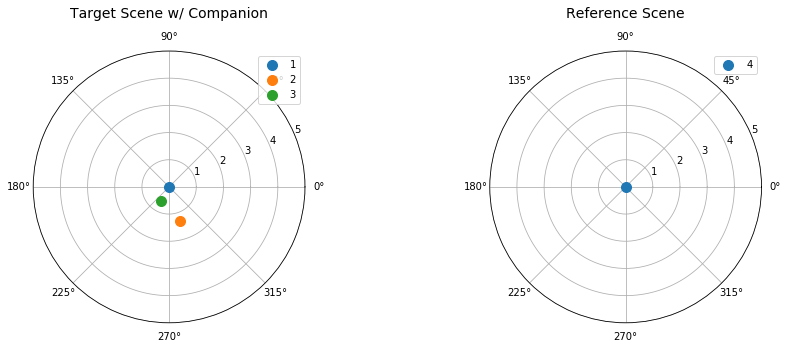

In [6]:
# The plot_scene convenience functions expect a scene to have a list of sources, whereas the PSF subtraction source
# in a pandeia configuration dictionary is a single source, and not part of a list.
reference = {}
reference['scene'] = [config['strategy']['psf_subtraction_source']]

plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
scene.plot_scene(config['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
scene.plot_scene(reference['scene'],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]


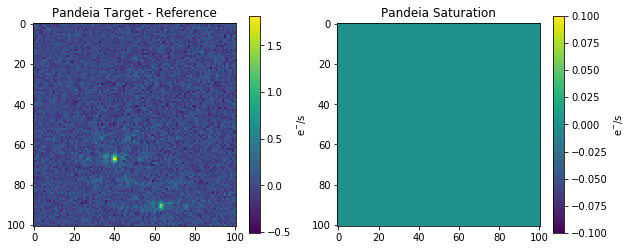

In [7]:
pandeia_result = pandeia_calculation(deepcopy(config))

subtracted_slope = pandeia_result['2d']['detector']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(pandeia_result['2d']['detector'])
plt.title('Pandeia Target - Reference')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(pandeia_result['2d']['saturation'])
plt.title('Pandeia Saturation')
plt.colorbar().set_label('e$^{-}$/s')

In order to run the same calculation via panCAKE, the convenience function ``engine.calculate_subtracted`` will generate similar results to Pandeia's optimally-subtracted calculation:

        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]


Target had 0 NAN values


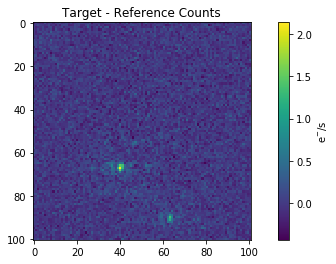

In [8]:
pancake_result = engine.calculate_subtracted(config)

subtracted_slope = pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

To demonstrate the difference between the two data reductions, the following plot shows the result of subtracting the panCAKE image from the pandeia image.

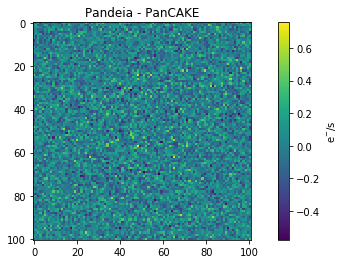

In [9]:
difference_image = pandeia_result['2d']['detector'] - pancake_result['subtracted']

plt.figure(figsize=(10,4))
plt.imshow(difference_image)
plt.title('Pandeia - PanCAKE')
plt.colorbar().set_label('e$^{-}$/s')

In this case, both results are quite close, although the panCAKE result has a slightly greater remaining residual.

### Wave Sampling

An aside on performance and accuracy: The ```engine.options.wave_sampling``` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting ```engine.options.wave_sampling = 11``` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By ```engine.options.wave_sampling = 41```, one can expect agreement to within roughly 1%.

### On-the-fly PSF Calculations

The Pandeia engine relies on a library of precomputed PSFs that are sparsely sampled across the coronagraphic field of view. For the MIRI coronagraphs, this sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

Pandeia-Coronagraphy gives the option (```engine.options.on_the_fly_PSFs```) to circumvent the use of this precomputed library and force recomputing each PSF on the fly in WebbPSF. We'll toggle it to True, at the cost of some speed.

The example below shoes a calculation with 11 data points (using on-the-fly PSFs), and one with 51.

        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]


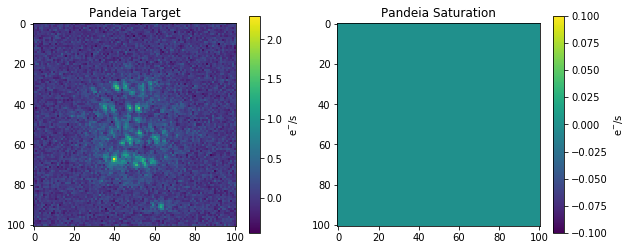

In [10]:
target_only_config = deepcopy(config)
target_only_config['strategy']['psf_subtraction'] = 'target_only'

pandeia_target_only = pandeia_calculation(deepcopy(target_only_config))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(pandeia_target_only['2d']['detector'])
plt.title('Pandeia Target')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(pandeia_target_only['2d']['saturation'])
plt.title('Pandeia Saturation')
plt.colorbar().set_label('e$^{-}$/s')

        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]
        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]


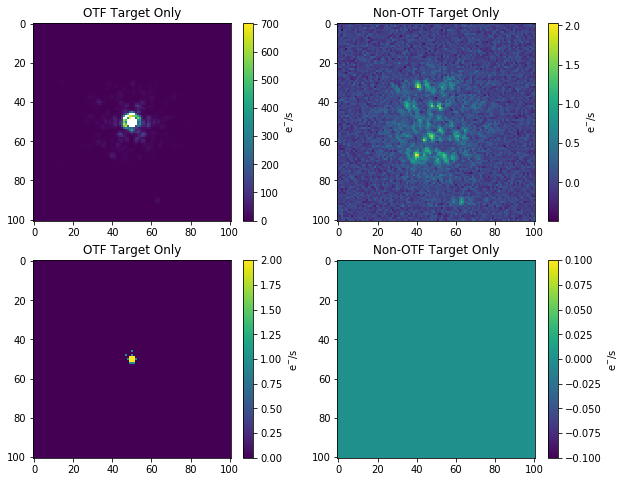

In [11]:
past_psf = engine.options.on_the_fly_PSFs
past_saturation = engine.options.pandeia_effects['saturation']
engine.options.on_the_fly_PSFs = True
engine.options.wave_sampling = 31

otf_result = engine.perform_calculation(target_only_config)

engine.options.on_the_fly_PSFs = False

non_otf_result = engine.perform_calculation(target_only_config)

engine.options.on_the_fly_PSFs = past_psf
engine.options.set_saturation(past_saturation)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(otf_result['2d']['detector'])
plt.title('OTF Target Only')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(222)
plt.imshow(non_otf_result['2d']['detector'])
plt.title('Non-OTF Target Only')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(223)
plt.imshow(otf_result['2d']['saturation'])
plt.title('OTF Target Only')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(224)
plt.imshow(non_otf_result['2d']['saturation'])
plt.title('Non-OTF Target Only')
plt.colorbar().set_label('e$^{-}$/s')

        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]
        Use astropy.modeling.blackbody.blackbody_nu instead. [pandeia.engine.sed]


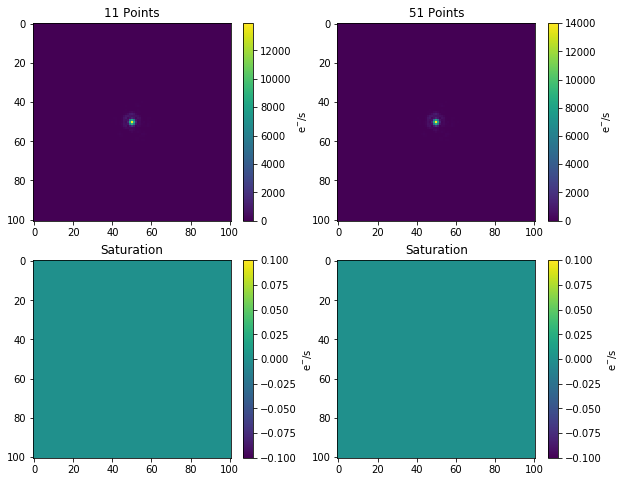

In [13]:
past_psf = engine.options.on_the_fly_PSFs
past_saturation = engine.options.pandeia_effects['saturation']
engine.options.on_the_fly_PSFs = True
engine.options.set_saturation(False)
engine.options.wave_sampling = 51

result_11 = engine.perform_calculation(target_only_config)

engine.options.wave_sampling = 151

result_51 = engine.perform_calculation(target_only_config)

engine.options.on_the_fly_PSFs = past_psf
engine.options.set_saturation(past_saturation)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(result_11['2d']['detector'])
plt.title('11 Points')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(222)
plt.imshow(result_51['2d']['detector'])
plt.title('51 Points')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(223)
plt.imshow(result_11['2d']['saturation'])
plt.title('Saturation')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(224)
plt.imshow(result_51['2d']['saturation'])
plt.title('Saturation')
plt.colorbar().set_label('e$^{-}$/s')

In [ ]:
past_psf = engine.options.on_the_fly_PSFs
engine.options.on_the_fly_PSFs = True

start_11 = time.time()
engine.options.wave_sampling = 11
pancake_result_11 = engine.calculate_subtracted(config)
subtracted_slope_11 = pancake_result_11['subtracted']
print("11-point On-the-fly result completed in {:.1f} seconds".format(time.time() - start_11))

start_51 = time.time()
engine.options.wave_sampling = 51
pancake_result_51 = engine.calculate_subtracted(config)
subtracted_slope_51 = pancake_result_51['subtracted']
print("51-point On-the-fly result completed in {:.1f} seconds".format(time.time() - start_51))

engine.options.on_the_fly_PSFs = past_psf

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(subtracted_slope_11)
plt.title('11 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(subtracted_slope_51)
plt.title('51 Wavelength Bins')
plt.colorbar().set_label('e$^{-}$/s')

In [ ]:
plt.imshow(centered_target - registered_ref)
plt.colorbar().set_label('e$^{-}$/s')
plt.title('After Reference-Subtraction')

# Optimizing Observation Parameters


In [ ]:
ngroup_list = range(2,8)

raw_images = []
refsub_images = []
for ngroup in ngroup_list:
    
    #Exposure parameters
    numberofgroups = ngroup
    numberofints = 1
    target['configuration']['detector']['ngroup'] = numberofgroups
    target['configuration']['detector']['nint'] = numberofints
    reference['configuration']['detector']['ngroup'] = numberofgroups
    reference['configuration']['detector']['nint'] = numberofints

    #Pandeia calculation
    occ_results, ref_results = engine.calculate_batch([target,reference])
    occ_slope = occ_results['2d']['detector']
    ref_slope = ref_results['2d']['detector']

    #PSF subtraction assuming photon noise, the normalization is done properly 
    centered_occ = occ_slope - np.nanmean(occ_slope)
    centered_ref = ref_slope - np.nanmean(ref_slope)
    reg_ref = analysis.register_to_target(centered_ref,centered_occ,rescale_reference=True)
    ref_sub = centered_occ - reg_ref
    
    raw_images.append(centered_occ)
    refsub_images.append(ref_sub)

In [ ]:
for raw, reduced in zip(raw_images,refsub_images):
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(raw)
    plt.title('Raw Data')
    plt.colorbar().set_label('e$^{-}$/s')
    plt.subplot(122)
    plt.imshow(reduced)
    plt.title('Reduced Data')
    plt.colorbar().set_label('e$^{-}$/s')

# Save Calculation File

Save out your scene and instrument parameters for quick loading with a future call to ```engine.load_calculation```

In [ ]:
engine.save_calculation(target,'mygreatcalculation.json')

# Save Pandeia Images

```engine.save_to_fits``` is provided as a convenience function for quickly saving out arrays or cubes to a FITS file. This doesn't preserve any header values. See http://docs.astropy.org/en/stable/io/fits/ for a more complete treatment of reading and writings FITS files in Python.

In [ ]:
# Save out 2d slop images
engine.save_to_fits(targ_results['2d']['detector'],'target_slope.fits')
engine.save_to_fits(ref_results['2d']['detector'],'reference_slope.fits')

# Save out cube
engine.save_to_fits(raw_images,'raw_cube.fits')

# Limiting Contrast Calculation


This is where we calculate the contrast as a function of exposure time. Note that in this example the limiting contrast is driven by:

1. detector noise, in the Pandeia model
2. photon noise on the speckles
3. TA error between target and reference. 

There is no error due to wavefront thermal drifts or dynamical vibrations 

For the occulted source, we'll copy the target calculation from before and pop the planet out of the scene list.

In [ ]:
occulted = deepcopy(target)
occulted['scene'].pop(-1)
occulted['scene'].pop(-1)

#and plot
scene.plot_scene(occulted['scene'],'Occulted Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

The unocculted source for the contrast normalization is just the target source moved from behind the coronagraphic mask.

In [ ]:
#copy the occulted calculation file
unocculted = deepcopy(occulted)
#apply an offset
unocculted['scene'][0]['position']['x_offset'] = 0.8 # arcsec
unocculted['scene'][0]['position']['y_offset'] = 0.8 # arcsec

unocculted['calculation']['effects']['saturation'] = False # Disable saturation

#and plot
scene.plot_scene(unocculted['scene'],'Unocculted Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

 We'll use the same reference as in the previous calculations.

In [ ]:
from scipy.signal import fftconvolve

def quick_contrast(occulted_image,unocculted_image,n_annuli=20):
    '''
    A quick and dirty contrast calculation just for demonstration
    purposes.
    '''
    # Convolve the unocculted image with an aperture and pick out the max 
    # as the normalization constant
    kernel = np.array([[0,0,1,0,0], #simple aperture
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [0,0,1,0,0]]).astype(float)
    unocc_aperture = fftconvolve(unocculted_image,kernel,mode='valid')
    norm = np.max(unocc_aperture)

    # Convolve reference-subtract and raw frames with the aperture as well
    occ_aperture = fftconvolve(occulted_image,kernel,mode='valid')

    # Compute radial distance from center (in pixels)
    indices = np.indices(unocc_aperture.shape)
    center = np.array(unocc_aperture.shape) / 2.
    radial = np.sqrt( (indices[0] - center[0])**2 + (indices[1] - center[1])**2 )
    # Compute 20 annuli (uniform in radius)
    radial_bins = np.linspace(0,np.max(radial),num=n_annuli)
    annuli_inds = np.digitize(radial,radial_bins)

    # Take the variance of raw and reference-subtracted images in each annulus and normalize by unocculted max
    contrast = np.array([np.std(occ_aperture[annuli_inds == a]) for a in np.unique(annuli_inds)]) / norm    
    return radial_bins, contrast

Now we'll iterate over exposure parameters and calculate the raw and reference-subtracted contrast at each iteration.

In [ ]:
n_annuli = 30
ngroup_list = range(2,11)

raw_contrast_list = []
refsub_contrast_list = []
for ngroup in ngroup_list:
    # Exposure parameters
    numberofgroups = ngroup
    numberofints = 1
    occulted['configuration']['detector']['ngroup'] = numberofgroups
    occulted['configuration']['detector']['nint'] = numberofints
    unocculted['configuration']['detector']['ngroup'] = 200
    unocculted['configuration']['detector']['nint'] = 10
    reference['configuration']['detector']['ngroup'] = numberofgroups
    reference['configuration']['detector']['nint'] = numberofints

    # Pandeia calculation
    occ_results, unocc_results, ref_results = engine.calculate_batch([occulted,unocculted,reference])
    occ_slope = occ_results['2d']['detector']
    unocc_slope = unocc_results['2d']['detector']
    ref_slope = ref_results['2d']['detector']

    # PSF subtraction assuming photon noise, the normalization is done properly 
    centered_occ = occ_slope - np.nanmean(occ_slope)
    centered_ref = ref_slope - np.nanmean(ref_slope)
    reg_ref = analysis.register_to_target(centered_ref,centered_occ)
    ref_sub = centered_occ - reg_ref

    radial_bins, raw_contrast = quick_contrast(occ_slope,unocc_slope,n_annuli=n_annuli)
    radial_bins, refsub_contrast = quick_contrast(ref_sub,unocc_slope,n_annuli=n_annuli)

    raw_contrast_list.append(raw_contrast)
    refsub_contrast_list.append(refsub_contrast)


In [ ]:
pix_scale = 0.032 # see https://jwst-docs.stsci.edu/display/JTI/NIRCam+Imaging
mask_radii = 0.4 # see https://jwst-docs.stsci.edu/display/JTI/NIRCam+Coronagraphic+Imaging

plt.figure(figsize=(10,5))
for i,contrast in enumerate(raw_contrast_list):
    plt.semilogy(radial_bins * pix_scale,contrast,label='Nints=1, Ngroups={}'.format(ngroup_list[i]))
    plt.fill_between([0,mask_radii],1e-6,20,alpha=0.2,lw=0,color=[0.5,0.5,0.5])
    plt.xlabel('Radial Separation (arcsec)')
    plt.ylabel('Contrast')
    plt.xlim(0,2.1)
    plt.ylim(1e-6,1e-2)
    plt.title('Raw Target, {} V={}, Reference {}, V={}'.format(target_Sp,target_mV,ref_Sp,ref_mV),fontsize=15)
    plt.legend(loc='upper right')
    
plt.figure(figsize=(10,5))
for i,contrast in enumerate(refsub_contrast_list):
    plt.semilogy(radial_bins * pix_scale,contrast,label='Nints=1, Ngroups={}'.format(ngroup_list[i]))
    plt.fill_between([0,mask_radii],1e-6,20,alpha=0.2,lw=0,color=[0.5,0.5,0.5])
    plt.xlabel('Radial Separation (arcsec)')
    plt.ylabel('Contrast')
    plt.xlim(0,2.1)
    plt.ylim(1e-6,1e-2)
    plt.title('Reduced Target, {} V={}, Reference {}, V={}'.format(target_Sp,target_mV,ref_Sp,ref_mV),fontsize=15)
    plt.legend(loc='upper right')
    